# Hay Data Exploration

### Price Correlations by Region using AMS Dataset

We want to explore correlations by locations and grade in the price of data in the California. Let's explore using the AMS dataset from the USDA, location here: https://www.ams.usda.gov

In [64]:
import csv
import pandas as pd
from pandas import Series

from statsmodels.tsa.stattools import adfuller

import numpy as np
from numpy import log

from matplotlib import pyplot
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import lag_plot

In [2]:
# Raw CSV files
ams_file_name = 'USDA_AMS_HayWeekly_All.csv'

# Load CSVs into Pandas dataframe
ams = pd.read_csv(ams_file_name)

In [3]:
# Explore basic structure
print(list(ams.columns.values))
ams[1:10]

['Week Ending Date', 'Location', 'Class', 'Package', 'Grade Description', 'Number of Tons', 'Bid Low', 'Bid High', 'Weighted Average', 'Pricing Point', 'Comment']


,Week Ending Date,Location,Class,Package,Grade Description,Number of Tons,Bid Low,Bid High,Weighted Average,Pricing Point,Comment
1,4/30/2005,"North Central/Northeast Kansas, KS",ALFALFA,Large Round,UTILITY/FAIR,200,45.0,45.0,45.00,Delivered,NaN
2,4/30/2005,"North Central/Northeast Kansas, KS",ALFALFA,Large Round,UTILITY/FAIR,725,30.0,40.0,37.76,FOB,NaN
3,4/30/2005,"North Central/Northeast Kansas, KS",ALFALFA,Mid Square,SUPREME,175,110.0,120.0,114.29,FOB,NaN
4,4/30/2005,"Northwest Kansas, KS",ALFALFA,Chopped,UTILITY/FAIR,900,65.0,70.0,66.39,Delivered,NaN
5,4/30/2005,"Northwest Kansas, KS",ALFALFA,Large Round,UTILITY/FAIR,100,50.0,50.0,50.00,Delivered,NaN
6,4/30/2005,"Northwest Kansas, KS",ALFALFA,Large Round,UTILITY/FAIR,700,40.0,45.0,43.57,FOB,NaN
7,4/30/2005,"Northwest Kansas, KS",ALFALFA,Mid Square,GOOD/PREMIUM,25,90.0,90.0,90.00,FOB,NaN
8,4/30/2005,"Northwest Kansas, KS",ALFALFA,Mid Square,SUPREME,50,120.0,120.0,120.00,FOB,NaN
9,4/30/2005,"Northwest Kansas, KS",ALFALFA,Small Square,GOOD/PREMIUM,25,150.0,150.0,150.00,FOB,NaN


We do not need the feature 'Class', because every class is alfalfa. We do not need 'Bid Low' and 'Bid High' because we are only interested in the weighted average price. So let's delete these observations and work with a smaller dataset.

In [4]:
ams = ams[['Week Ending Date', 'Location', 'Package', 'Grade Description', 'Number of Tons',  'Weighted Average', 'Pricing Point', 'Comment']]

### Preprocessing
Let's explore each column, cleaning as we explore.

In [5]:
print(ams['Pricing Point'].value_counts().sort_index().to_string())

Delivered    11183
FOB          44785


‘Delivered’ adds freight charges and thus skews the true price. ‘FOB’ (freight on board) does not include freight, and thus reflects a more accurate price. So we will drop the ‘Pricing Point’ observations that are not ‘FOB’. Once we drop those observations, the only value remaining will be ‘FOB’, so we might as well drop the entire feature. 

In [6]:
ams = ams.drop(ams[ams['Pricing Point'] != 'FOB'].index)
ams[1:10]

,Week Ending Date,Location,Package,Grade Description,Number of Tons,Weighted Average,Pricing Point,Comment
3,4/30/2005,"North Central/Northeast Kansas, KS",Mid Square,SUPREME,175,114.29,FOB,NaN
6,4/30/2005,"Northwest Kansas, KS",Large Round,UTILITY/FAIR,700,43.57,FOB,NaN
7,4/30/2005,"Northwest Kansas, KS",Mid Square,GOOD/PREMIUM,25,90.00,FOB,NaN
8,4/30/2005,"Northwest Kansas, KS",Mid Square,SUPREME,50,120.00,FOB,NaN
9,4/30/2005,"Northwest Kansas, KS",Small Square,GOOD/PREMIUM,25,150.00,FOB,NaN
14,4/30/2005,"South Central Kansas, KS",Chopped,PREMIUM/SUPREME,200,72.00,FOB,NaN
15,4/30/2005,"South Central Kansas, KS",Compressed Bales,SUPREME,345,140.00,FOB,NaN
16,4/30/2005,"South Central Kansas, KS",Large Round,UTILITY/FAIR,100,42.50,FOB,NaN
17,4/30/2005,"South Central Kansas, KS",Large Square,PREMIUM/SUPREME,295,100.08,FOB,NaN


In [7]:
print(ams['Location'].value_counts().sort_index().to_string())

Antelope Valley - Mojave Desert, CA                 618
Arthur, IL                                          460
Bethalto, IL                                        249
Blythe - Parker, CA                                1582
Central/East Central, NV                            486
Crook, Deschutes, Jefferson, Wasco Counties, OR    1442
Eastern Oregon, OR                                  716
Escalon - Merced - Modesto - Turlock, CA             24
Hanford - Corcoran - Tulare, CA                     821
Hanford/Tulare/Visalia, CA                            3
Harney County, OR                                   596
Idaho, ID                                          3189
Imperial Valley, CA                                2475
Kern County, CA                                    1456
Klamath Basin, OR                                  1529
Lake County, OR                                    2707
Los Banos-Dos Palos, CA                            1567
North Central/Northeast Kansas, KS              

We are only interested in exploring grade and price correlations in California. So let's drop all rows that are now in California.  

In [8]:
ams=ams[ams.Location.str.contains(', CA')]
print(ams['Location'].value_counts().sort_index().to_string())

Antelope Valley - Mojave Desert, CA           618
Blythe - Parker, CA                          1582
Escalon - Merced - Modesto - Turlock, CA       24
Hanford - Corcoran - Tulare, CA               821
Hanford/Tulare/Visalia, CA                      3
Imperial Valley, CA                          2475
Kern County, CA                              1456
Los Banos-Dos Palos, CA                      1567
Northern - Intermountain Areas, CA           1309
Petaluma, CA                                   17
Region 1: North Inter-Mountain, CA            859
Region 2: Sacramento Valley, CA              1004
Region 3: Northern San Joaquin Valley, CA     919
Region 4: Central San Joaquin Valley, CA      279
Region 5: Southern California, CA             678
Region 6: Southeast California, CA           1715
Sacramento Valley, CA                        1958
South-Central Coastal Areas, CA                20
Tracy-Patterson-Stockton, CA                 1331
Western Fresno-Madera Counties, CA            826


Since the California Hay market is so big, the USDA decided to track locations in California by region instead of just by a geographical location (Region 1 thru Region 6). This decision was made about half way through. After consulting with the USDA, they provided us with a mapping of the old location names with the updated region names. We need to rename the old geographical locations with the updated region names. Also, we will drop any locations that do not have an associated region.

In [9]:
#Rename Region 1
ams['Location']=ams['Location'].replace(['Northern - Intermountain Areas, CA'],['Region 1: North Inter-Mountain, CA'])
#Rename Region 2
ams['Location']=ams['Location'].replace(['Sacramento Valley, CA'],['Region 2: Sacramento Valley, CA'])
#Rename Region 3
ams['Location']=ams['Location'].replace(['Escalon - Merced - Modesto - Turlock, CA','Los Banos-Dos Palos, CA','Tracy-Patterson-Stockton, CA'],['Region 3: Northern San Joaquin Valley, CA','Region 3: Northern San Joaquin Valley, CA','Region 3: Northern San Joaquin Valley, CA'])
#Rename Region 4
ams['Location']=ams['Location'].replace(['Hanford - Corcoran - Tulare, CA','Hanford/Tulare/Visalia, CA','Western Fresno-Madera Counties, CA'],['Region 4: Central San Joaquin Valley, CA','Region 4: Central San Joaquin Valley, CA','Region 4: Central San Joaquin Valley, CA'])
#Rename Region 5
ams['Location']=ams['Location'].replace(['Antelope Valley - Mojave Desert, CA','Kern County, CA'],['Region 5: Southern California, CA','Region 5: Southern California, CA'])
#Rename Region 6
ams['Location']=ams['Location'].replace(['Blythe - Parker, CA','Imperial Valley, CA'],['Region 6: Southeast California, CA','Region 6: Southeast California, CA'])

#ignore locations without region (Petaluma, South-Central Coastal areas)
ams=ams[ams.Location.str.contains('Region')]

#Just to confirm changes
print(ams['Location'].value_counts().sort_index().to_string())

Region 1: North Inter-Mountain, CA           2168
Region 2: Sacramento Valley, CA              2962
Region 3: Northern San Joaquin Valley, CA    3841
Region 4: Central San Joaquin Valley, CA     1929
Region 5: Southern California, CA            2752
Region 6: Southeast California, CA           5772


In [10]:
print(ams['Grade Description'].value_counts().sort_index().to_string())

FAIR               3451
FAIR/GOOD           326
GOOD               4091
GOOD/PREMIUM       2673
PREMIUM            5527
PREMIUM/SUPREME     526
SUPREME            2531
UTILITY             253
UTILITY/FAIR         46


There are five standard grades tracked by Hay buyers and sellers: Utility, Fair, Good, Premium, and Supreme. The USDA create an additional five, which are borderline grades when a bale is somewhere between two grades. After consulting with the USDA, they confirmed that the hybrid grades were always closer to the better grade. So we will convert all hybrid grades to the ceiling grade, so that we have a smaller dimensionality of data to work with. 

Also, Utility grade is considered a by-product by buyers and sellers. It's the lowest grade and is essentially junk. It is sold to the highest bidder, which is usually very low. Farmers just sell it for whatever they can get just to get rid of it. As such, it does not follow the market like the other four grades, and many times the sales are not reported, resulting in missing observations in the dataset. As such, we will delete all observations that are Grade Utility. 

In [11]:
ams['Grade Description']=ams['Grade Description'].replace(['FAIR/GOOD','GOOD/PREMIUM','PREMIUM/SUPREME','UTILITY/FAIR'],['GOOD','PREMIUM','SUPREME','FAIR'])
ams=ams[ams['Grade Description']!='UTILITY']
#Just to confirm total of rows
print(ams['Grade Description'].value_counts().sort_index().to_string())

FAIR       3497
GOOD       4417
PREMIUM    8200
SUPREME    3057


In [12]:
print(ams['Comment'].value_counts().sort_index().to_string())

Baleage                         15
Baled Too Dry                   15
Bleached                        54
Bottom Bales                     3
CRP                              4
Clippings                       36
Contracted                     198
Erosion Control                  1
Excessive Moisture             337
Export                         350
Frost Damage                    37
Grassy                        1188
Heavy rain damage               37
Moldy                            8
New Crop                         5
Old Crop                       206
Organic                        259
Per Bale                        18
Picked Up Out of the Field       1
Rain Damage                    906
Retail/Stable                 1271
Roundup Ready                    1
Small Lots                       1
Tarped                          13
Very High Testing               56
Volunteer                        3
Weedy                          579


Price is reported generally by ton. However, sometimes prices are reported by bale. This can skew our data, so we'll remove all prices reported by bale. Organic hay and tarped hay are specialty items that are priced higher than the majority of hay, and can add outliers to our data. Since we are not interested in  Organic hay and tarped hay, we will remove all observations.

Remove observations with COMMENTS
* Per Bale
* Organic
* Tarped

In [13]:
ams=ams.drop(ams[ams.Comment.str.contains('Per Bale|Organic|Tarped', na=False)].index)
#Just to confirm total of rows
print(ams['Comment'].value_counts().sort_index().to_string())

Baleage                         15
Baled Too Dry                   15
Bleached                        54
Bottom Bales                     3
CRP                              4
Clippings                       36
Contracted                     198
Erosion Control                  1
Excessive Moisture             337
Export                         350
Frost Damage                    37
Grassy                        1188
Heavy rain damage               37
Moldy                            8
New Crop                         5
Old Crop                       206
Picked Up Out of the Field       1
Rain Damage                    906
Retail/Stable                 1271
Roundup Ready                    1
Small Lots                       1
Very High Testing               56
Volunteer                        3
Weedy                          579


In [14]:
print(ams['Package'].value_counts().sort_index().to_string())

Chopped                 128
Cubes                   143
In Windrow               24
Large Square            562
Mid Square                1
Pellets 15% Suncured      1
Small Square              7
Standing                 29


“Small Squared” packaged hay is priced differently that the rest of the packages. We are not so concerned with small squared hay, so we'll delete all observations of small squared hay. 

In [15]:
ams=ams.drop(ams[ams.Package.str.contains('Small Square', na=False)].index)
#Just to confirm total of rows
print(ams['Package'].value_counts().sort_index().to_string())

Chopped                 128
Cubes                   143
In Windrow               24
Large Square            562
Mid Square                1
Pellets 15% Suncured      1
Standing                 29


Let's remove some of the features we no longer need: 'Package', 'Pricing Point', and 'Comment'.

In [16]:
ams = ams.drop('Package', 1)
ams = ams.drop('Pricing Point', 1)
ams = ams.drop('Comment', 1)

Now it is time to process our data into a tidy format we can explore. We will create a new dataframe with features equal to the concatenation of the six California regions + tons and he six California regions + grade. 

In [17]:
print(list(ams.columns.values))
ams[200:210]

['Week Ending Date', 'Location', 'Grade Description', 'Number of Tons', 'Weighted Average']


,Week Ending Date,Location,Grade Description,Number of Tons,Weighted Average
419,6/4/2005,"Region 4: Central San Joaquin Valley, CA",FAIR,1231,128.06
420,6/4/2005,"Region 4: Central San Joaquin Valley, CA",GOOD,2640,144.24
421,6/4/2005,"Region 4: Central San Joaquin Valley, CA",PREMIUM,825,165.00
422,6/4/2005,"Region 4: Central San Joaquin Valley, CA",SUPREME,650,182.00
427,6/4/2005,"Region 6: Southeast California, CA",GOOD,3764,137.80
428,6/4/2005,"Region 6: Southeast California, CA",PREMIUM,650,161.92
429,6/4/2005,"Region 6: Southeast California, CA",PREMIUM,325,151.54
430,6/4/2005,"Region 6: Southeast California, CA",SUPREME,100,145.00
431,6/4/2005,"Region 6: Southeast California, CA",SUPREME,3770,150.93
432,6/4/2005,"Region 5: Southern California, CA",GOOD,130,115.00


In [18]:
ams_df = ams.copy()
#fill new dataframe
ams_df['Location']=ams_df['Location'] + '|'+ ams_df['Grade Description']
ams_df=ams_df.drop('Grade Description',1)
ams_df['weight'] = ams_df['Number of Tons'] / ams_df.groupby(['Week Ending Date','Location'])['Number of Tons'].transform('sum')
ams_df['Week Ending Date']=pd.to_datetime(ams_df['Week Ending Date'])
wp = lambda x: np.average(x, weights=ams_df.loc[x.index,'weight'])
ams_uniques_df = ams_df.groupby(['Week Ending Date','Location']).agg({'Number of Tons': np.sum,'Weighted Average' : wp}).reset_index()
ams_uniques_df=pd.melt(ams_uniques_df, id_vars=['Week Ending Date','Location'],value_vars=['Number of Tons','Weighted Average'])
ams_uniques_df['Location']=ams_uniques_df['Location'] + '|'+ ams_uniques_df['variable']
ams_uniques_df=ams_uniques_df.drop('variable',1)
ams_df = pd.pivot_table(ams_uniques_df, values='value', index=['Week Ending Date'], columns=['Location'], fill_value=0).reset_index()

In [19]:
ams_df[1:10]

Location,Week Ending Date,"Region 1: North Inter-Mountain, CA|FAIR|Number of Tons","Region 1: North Inter-Mountain, CA|FAIR|Weighted Average","Region 1: North Inter-Mountain, CA|GOOD|Number of Tons","Region 1: North Inter-Mountain, CA|GOOD|Weighted Average","Region 1: North Inter-Mountain, CA|PREMIUM|Number of Tons","Region 1: North Inter-Mountain, CA|PREMIUM|Weighted Average","Region 1: North Inter-Mountain, CA|SUPREME|Number of Tons","Region 1: North Inter-Mountain, CA|SUPREME|Weighted Average","Region 2: Sacramento Valley, CA|FAIR|Number of Tons",...,"Region 5: Southern California, CA|SUPREME|Number of Tons","Region 5: Southern California, CA|SUPREME|Weighted Average","Region 6: Southeast California, CA|FAIR|Number of Tons","Region 6: Southeast California, CA|FAIR|Weighted Average","Region 6: Southeast California, CA|GOOD|Number of Tons","Region 6: Southeast California, CA|GOOD|Weighted Average","Region 6: Southeast California, CA|PREMIUM|Number of Tons","Region 6: Southeast California, CA|PREMIUM|Weighted Average","Region 6: Southeast California, CA|SUPREME|Number of Tons","Region 6: Southeast California, CA|SUPREME|Weighted Average"
1,2005-05-14,0,0.000,0,0.000000,50,140.000000,0,0.000000,800,...,200,170.000000,200,135.000000,600,147.500000,1969,165.183850,10426,154.129584
2,2005-05-21,0,0.000,0,0.000000,320,135.000000,0,0.000000,1100,...,750,171.000000,0,0.000000,2200,142.228182,2525,165.051881,10382,154.627128
3,2005-05-28,0,0.000,0,0.000000,0,0.000000,0,0.000000,350,...,525,174.622381,400,135.000000,4250,145.706000,1670,161.796557,7223,156.230814
4,2005-06-04,0,0.000,0,0.000000,0,0.000000,0,0.000000,1650,...,0,0.000000,0,0.000000,7764,137.853130,1380,153.042391,9545,151.284060
5,2005-06-11,0,0.000,2100,131.666667,25,135.000000,800,149.690000,6075,...,0,0.000000,485,114.175258,8560,139.225041,1300,154.441154,1550,148.709032
6,2005-06-18,200,80.625,0,0.000000,1250,135.440000,875,140.858286,3850,...,150,175.000000,12900,118.674419,7580,139.245000,2625,155.140476,0,0.000000
7,2005-06-25,100,85.000,1400,123.214286,4600,133.785000,4725,145.208148,4250,...,0,0.000000,860,119.531221,4457,133.981387,2525,142.725248,0,0.000000
8,2005-07-02,0,0.000,200,123.750000,325,131.157692,1750,149.284571,2050,...,0,0.000000,10200,114.268725,5312,131.456642,725,149.310345,0,0.000000
9,2005-07-09,300,100.000,2125,122.590000,1250,125.199200,2950,151.780000,8320,...,0,0.000000,15325,114.745889,4274,126.433318,3211,132.383790,0,0.000000


In [20]:
#save
ams_df.to_csv('USDA_AMS_HayWeekly-CA.csv')

We want to explore data by the month, so we'll need to covert weeks to months and downsample the data.

In [34]:
ams_df['Year_Month'] = ams_df['Week Ending Date'].map(lambda x: str(x.year) + '-' + x.strftime('%m') + '-1')
columns_list_series=list(ams_df)
ams_month_df = pd.DataFrame(columns=columns_list_series)
features={}
for column in columns_list_series:
    if 'Region' in column:
        if 'of Tons' in column:
            ams_df[column]=ams_df[column].astype(int)
            features[column] = np.sum
            #we need calculate weight, so need add extra columns
            ams_df[column.replace('Number of Tons','weight')] = ams_df[column] / ams_df.groupby(['Year_Month'])[column].transform('sum')            
        if 'Weighted Average' in column:
            ams_df[column]=ams_df[column].astype(int)
            features[column] = lambda x: np.ma.average(x, weights=ams_df.loc[x.index,x.name.replace('Weighted Average','weight')])

ams_month_df = ams_df.groupby(['Year_Month']).agg(features).reset_index()
ams_month_df = ams_month_df.replace(0, ams_month_df.replace([0], [None]))
ams_month_df = ams_month_df.interpolate(method = 'values')
ams_month_df[0:20]

,Year_Month,"Region 6: Southeast California, CA|SUPREME|Number of Tons","Region 3: Northern San Joaquin Valley, CA|SUPREME|Number of Tons","Region 1: North Inter-Mountain, CA|PREMIUM|Number of Tons","Region 6: Southeast California, CA|GOOD|Weighted Average","Region 2: Sacramento Valley, CA|GOOD|Number of Tons","Region 3: Northern San Joaquin Valley, CA|SUPREME|Weighted Average","Region 2: Sacramento Valley, CA|FAIR|Number of Tons","Region 1: North Inter-Mountain, CA|SUPREME|Number of Tons","Region 3: Northern San Joaquin Valley, CA|FAIR|Weighted Average",...,"Region 5: Southern California, CA|GOOD|Number of Tons","Region 4: Central San Joaquin Valley, CA|SUPREME|Weighted Average","Region 1: North Inter-Mountain, CA|FAIR|Number of Tons","Region 6: Southeast California, CA|FAIR|Weighted Average","Region 5: Southern California, CA|SUPREME|Weighted Average","Region 3: Northern San Joaquin Valley, CA|PREMIUM|Weighted Average","Region 4: Central San Joaquin Valley, CA|PREMIUM|Weighted Average","Region 1: North Inter-Mountain, CA|SUPREME|Weighted Average","Region 4: Central San Joaquin Valley, CA|SUPREME|Number of Tons","Region 2: Sacramento Valley, CA|SUPREME|Weighted Average"
0,2005-05-1,49039.000000,6137.0,370.0,142.093168,8590.000000,177.972462,3325.0,NaN,70.000000,...,9961.0,179.571268,NaN,135.000000,170.404762,155.533771,157.913566,NaN,1782.00,156.707692
1,2005-06-1,11095.000000,6448.0,5875.0,137.509573,7475.000000,179.065602,15825.0,6400.000000,117.827586,...,7180.0,182.984192,300.0,117.924184,175.000000,161.056057,161.872885,144.816406,1708.00,162.857143
2,2005-07-1,5772.500000,12816.0,14369.0,126.134769,12807.000000,180.431492,21570.0,6150.000000,121.621914,...,10730.0,188.970046,1350.0,114.754237,173.750000,159.530702,168.223620,150.056911,4340.00,161.962264
3,2005-08-1,450.000000,5192.0,11905.0,125.364621,5320.000000,180.682781,23013.0,1575.000000,123.952572,...,6100.0,185.197183,350.0,109.633093,172.500000,162.644428,171.167785,151.587302,710.00,161.365854
4,2005-09-1,1025.000000,4610.0,17500.0,125.207141,7435.000000,181.834056,3785.0,2375.000000,125.466989,...,744.0,189.792178,2750.0,98.788664,171.250000,162.262328,172.188414,148.915789,1304.00,169.574468
5,2005-10-1,1600.000000,16281.0,9525.0,130.799141,3506.000000,192.194890,1650.0,4175.000000,115.278562,...,1928.0,195.788308,2000.0,107.563514,170.000000,146.099321,174.776283,151.850299,4020.00,167.732441
6,2005-11-1,1530.000000,3970.0,605.0,126.274499,2345.666667,192.614610,250.0,1550.000000,120.000000,...,2940.0,190.582335,1550.0,97.348527,168.962418,166.897436,162.853659,147.225806,2004.00,178.875000
7,2005-12-1,1425.000000,400.0,110.0,131.572125,1185.333333,194.725000,275.0,90.000000,135.000000,...,450.0,125.000000,1000.0,102.631309,167.924837,170.000000,170.166667,155.000000,150.00,182.653061
8,2006-01-1,4800.000000,765.0,1475.0,131.354143,25.000000,199.450980,300.0,329.166667,137.857143,...,250.0,142.954545,400.0,105.804348,166.887255,179.320000,175.000000,151.065574,212.50,185.000000
9,2006-02-1,15822.000000,165.0,250.0,113.197432,83.333333,193.030303,175.0,568.333333,139.444444,...,1500.0,160.909091,200.0,101.138743,165.849673,166.046512,159.894737,147.131148,275.00,185.000000


In [57]:
#save
ams_month_df.to_csv('USDA_AMS_HayMonthly-CA.csv')

In [53]:
corr_df = ams_month_df.copy()
corr_df = corr_df.filter(like='Average',axis=1)
corr_df = corr_df.corr()
corr_df.to_csv('USDA_AMS_HayMonthly-CA-CORR.csv')
print corr_df

                                                    Region 6: Southeast California, CA|GOOD|Weighted Average  \
Region 6: Southeast California, CA|GOOD|Weighte...                                           1.000000          
Region 3: Northern San Joaquin Valley, CA|SUPRE...                                           0.868008          
Region 3: Northern San Joaquin Valley, CA|FAIR|...                                           0.861004          
Region 2: Sacramento Valley, CA|PREMIUM|Weighte...                                           0.845159          
Region 4: Central San Joaquin Valley, CA|FAIR|W...                                           0.829524          
Region 2: Sacramento Valley, CA|FAIR|Weighted A...                                           0.877058          
Region 6: Southeast California, CA|PREMIUM|Weig...                                           0.949433          
Region 2: Sacramento Valley, CA|GOOD|Weighted A...                                           0.861354   

### Charts and Graphs
Let's look at the correlations we have so far. The first 3 graphs are of line graph correlations of the regions and grades in various combinations. The final four graphs are of the Pearson correlation coefficient of the region-grade pairs presented in various formats (matrix, bar chart ranking, heat map, bubble animation story).    

In [36]:
%%HTML

<div class='tableauPlaceholder' id='viz1497811387070' style='position: relative'><noscript><a href='#'><img alt='Califronia Hay Prices ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;California_Hay_Prices_3&#47;CalifroniaHayPrices&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' /><param name='name' value='California_Hay_Prices_3&#47;CalifroniaHayPrices' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;California_Hay_Prices_3&#47;CalifroniaHayPrices&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1497811387070');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1020px';vizElement.style.height='1033px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

### Autocorrelation and Stationarity

We now want to look at each of the features individually. First, we'll want to check how correlated each feature is to itself when lagged. Then, we'll want to remove any trends from the feature and smooth the feature, and then again check it's autocorrelation. Finally, we will want to verify that the data is stationary, so that we can better create prediction models. We'll use the *Augmented Dickey-Fuller test*: 
* **Null Hypothesis (H0):** If accepted, it suggests the time series has a unit root, meaning
it is non-stationary. It has some time dependent structure.
* **Alternate Hypothesis (H1):** The null hypothesis is rejected; it suggests the time series
does not have a unit root, meaning it is stationary. It does not have time-dependent
structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such
as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the
threshold suggests we accept the null hypothesis (non-stationary).

* **p-value > 0.05:** Accept the null hypothesis (H0), the data has a unit root and is
non-stationary.
* **p-value <= 0.05:** Reject the null hypothesis (H0), the data does not have a unit root and
is stationary.

In [96]:
ams_month_price_df_no_year = ams_month_df[ams_month_df.columns.drop(list(ams_month_df.filter(regex = 'Tons')))]
ams_month_price_df_no_year = ams_month_price_df_no_year.drop('Year_Month', 1)
ams_month_price_df_no_year[0:10]

,"Region 6: Southeast California, CA|GOOD|Weighted Average","Region 3: Northern San Joaquin Valley, CA|SUPREME|Weighted Average","Region 3: Northern San Joaquin Valley, CA|FAIR|Weighted Average","Region 2: Sacramento Valley, CA|PREMIUM|Weighted Average","Region 4: Central San Joaquin Valley, CA|FAIR|Weighted Average","Region 2: Sacramento Valley, CA|FAIR|Weighted Average","Region 6: Southeast California, CA|PREMIUM|Weighted Average","Region 2: Sacramento Valley, CA|GOOD|Weighted Average","Region 3: Northern San Joaquin Valley, CA|GOOD|Weighted Average","Region 5: Southern California, CA|FAIR|Weighted Average",...,"Region 1: North Inter-Mountain, CA|PREMIUM|Weighted Average","Region 5: Southern California, CA|GOOD|Weighted Average","Region 5: Southern California, CA|PREMIUM|Weighted Average","Region 4: Central San Joaquin Valley, CA|SUPREME|Weighted Average","Region 6: Southeast California, CA|FAIR|Weighted Average","Region 5: Southern California, CA|SUPREME|Weighted Average","Region 3: Northern San Joaquin Valley, CA|PREMIUM|Weighted Average","Region 4: Central San Joaquin Valley, CA|PREMIUM|Weighted Average","Region 1: North Inter-Mountain, CA|SUPREME|Weighted Average","Region 2: Sacramento Valley, CA|SUPREME|Weighted Average"
0,142.093168,177.972462,70.000000,145.125000,126.000000,101.466165,162.590129,117.032014,121.171739,130.142857,...,135.675676,126.775223,171.027966,179.571268,135.000000,170.404762,155.533771,157.913566,NaN,156.707692
1,137.509573,179.065602,117.827586,145.311538,115.555556,100.932070,150.289272,128.408027,137.311044,130.689655,...,133.434043,148.420613,168.802926,182.984192,117.924184,175.000000,161.056057,161.872885,144.816406,162.857143
2,126.134769,180.431492,121.621914,136.570513,126.301709,102.727399,135.804488,121.831733,146.096799,127.067736,...,125.668244,117.289655,161.255591,188.970046,114.754237,173.750000,159.530702,168.223620,150.056911,161.962264
3,125.364621,180.682781,123.952572,144.741271,128.382445,104.109590,133.235000,128.540414,144.430994,128.000000,...,128.095758,103.114754,158.037234,185.197183,109.633093,172.500000,162.644428,171.167785,151.587302,161.365854
4,125.207141,181.834056,125.466989,152.374317,127.237569,109.536328,133.503212,136.780767,148.416027,127.232317,...,126.011429,137.690860,163.220238,189.792178,98.788664,171.250000,162.262328,172.188414,148.915789,169.574468
5,130.799141,192.194890,115.278562,162.138230,125.915541,109.727273,149.576721,141.912151,151.084634,128.527938,...,135.135433,145.600622,175.963720,195.788308,107.563514,170.000000,146.099321,174.776283,151.850299,167.732441
6,126.274499,192.614610,120.000000,167.396579,117.000000,92.000000,164.352688,137.941434,45.533333,122.461538,...,143.099174,66.136054,170.075238,190.582335,97.348527,168.962418,166.897436,162.853659,147.225806,178.875000
7,131.572125,194.725000,135.000000,180.759563,80.000000,111.000000,156.326785,133.970717,170.000000,130.000000,...,142.454545,160.000000,177.603885,125.000000,102.631309,167.924837,170.000000,170.166667,155.000000,182.653061
8,131.354143,199.450980,137.857143,181.945946,145.000000,130.000000,154.298727,130.000000,156.000000,136.666667,...,149.932203,121.000000,176.414894,142.954545,105.804348,166.887255,179.320000,175.000000,151.065574,185.000000
9,113.197432,193.030303,139.444444,181.646154,88.000000,130.000000,154.083159,137.916667,166.400000,143.333333,...,147.900000,25.000000,177.204620,160.909091,101.138743,165.849673,166.046512,159.894737,147.131148,185.000000



---------------------  Region 6: Southeast California, CA|GOOD|Weighted Average  ---------------------
raw data


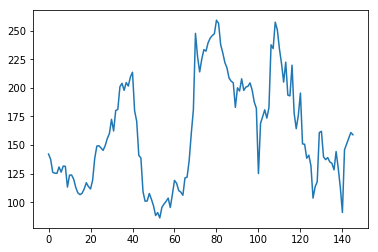

raw data lag ot t+1 / t


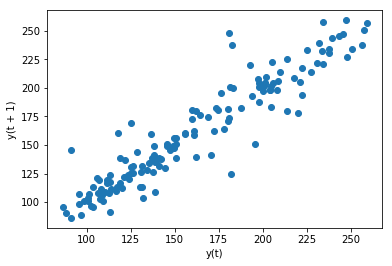

raw data autocorrelation


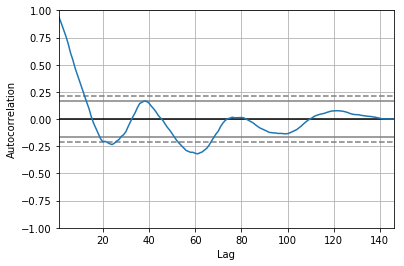

trend removed


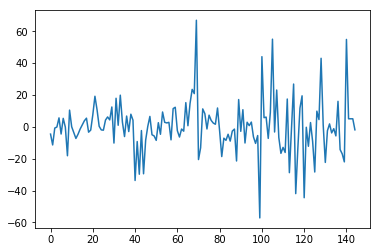

trend removed lag ot t+1 / t


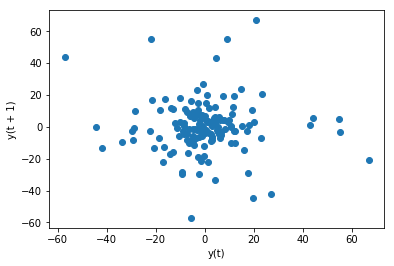

trend removed autocorrelation


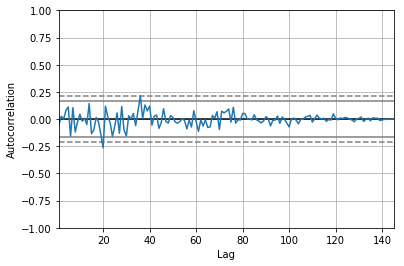

ADF Statistic: -12.541607
p-value: 0.000000
Critical Values:
	5%: -2.882
	1%: -3.477
	10%: -2.578
Region 6: Southeast California, CA|GOOD|Weighted Average : 'Stationary'

---------------------  Region 3: Northern San Joaquin Valley, CA|SUPREME|Weighted Average  ---------------------
raw data


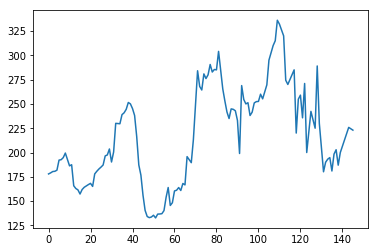

raw data lag ot t+1 / t


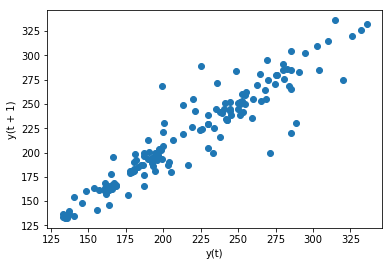

raw data autocorrelation


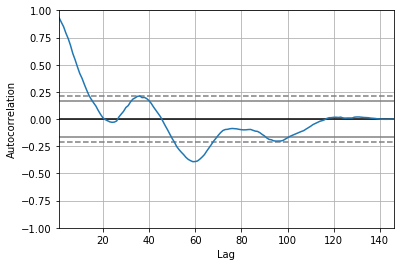

trend removed


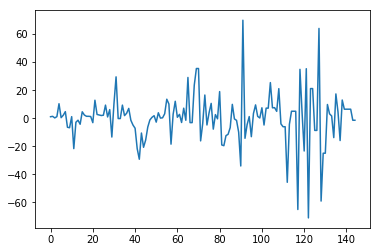

trend removed lag ot t+1 / t


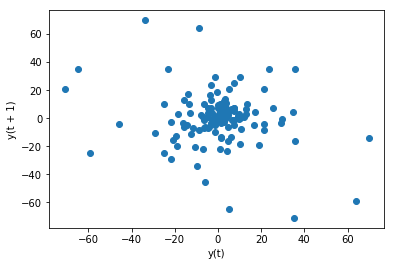

trend removed autocorrelation


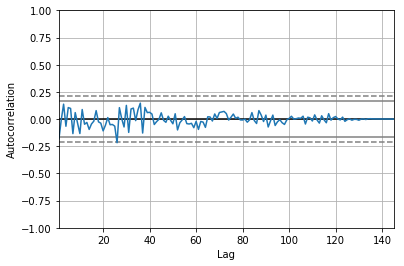

ADF Statistic: -14.304937
p-value: 0.000000
Critical Values:
	5%: -2.882
	1%: -3.477
	10%: -2.578
Region 3: Northern San Joaquin Valley, CA|SUPREME|Weighted Average : 'Stationary'

---------------------  Region 3: Northern San Joaquin Valley, CA|FAIR|Weighted Average  ---------------------
raw data


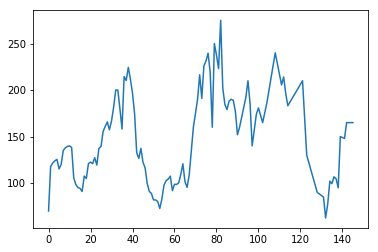

raw data lag ot t+1 / t


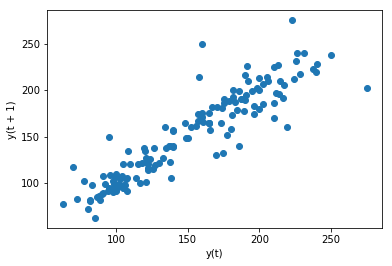

raw data autocorrelation


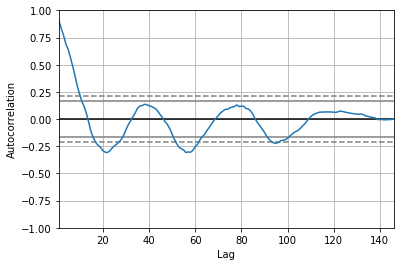

trend removed


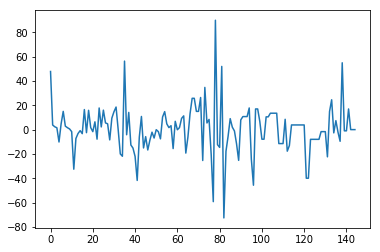

trend removed lag ot t+1 / t


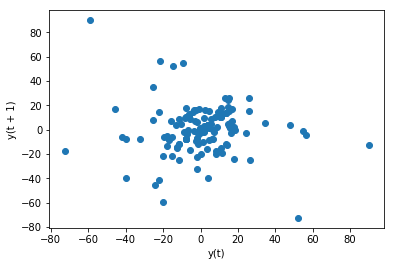

trend removed autocorrelation


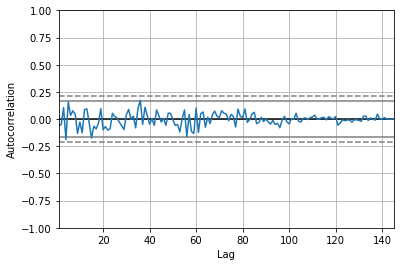

ADF Statistic: -4.969688
p-value: 0.000025
Critical Values:
	5%: -2.882
	1%: -3.478
	10%: -2.578
Region 3: Northern San Joaquin Valley, CA|FAIR|Weighted Average : 'Stationary'

---------------------  Region 2: Sacramento Valley, CA|PREMIUM|Weighted Average  ---------------------
raw data


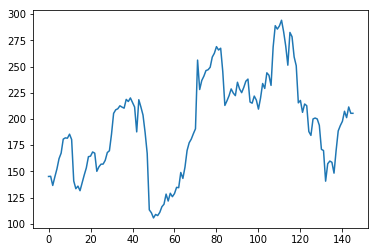

raw data lag ot t+1 / t


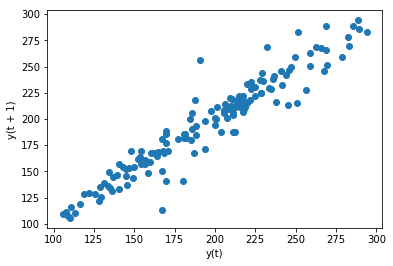

raw data autocorrelation


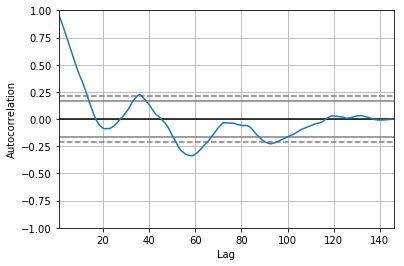

trend removed


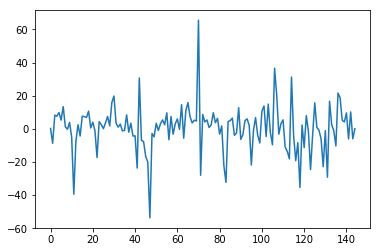

trend removed lag ot t+1 / t


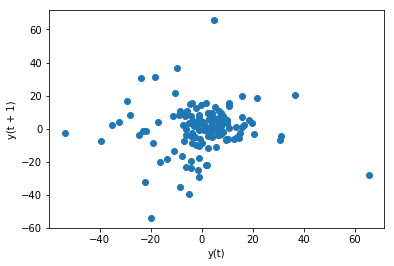

trend removed autocorrelation


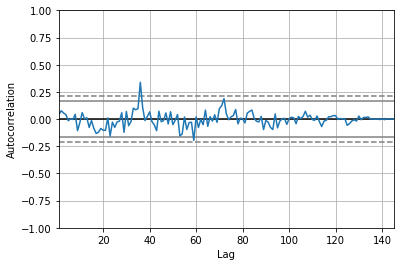

ADF Statistic: -11.398472
p-value: 0.000000
Critical Values:
	5%: -2.882
	1%: -3.477
	10%: -2.578
Region 2: Sacramento Valley, CA|PREMIUM|Weighted Average : 'Stationary'

---------------------  Region 4: Central San Joaquin Valley, CA|FAIR|Weighted Average  ---------------------
raw data


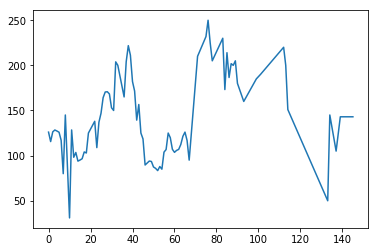

raw data lag ot t+1 / t


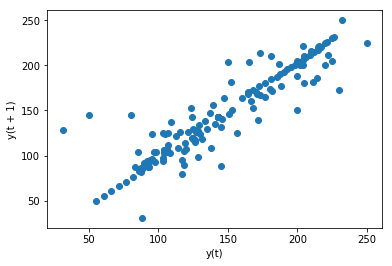

raw data autocorrelation


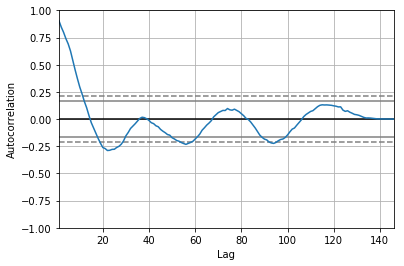

trend removed


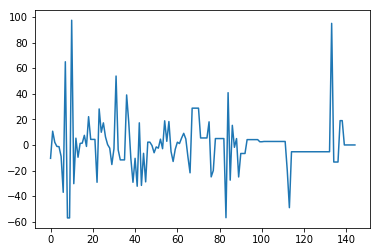

trend removed lag ot t+1 / t


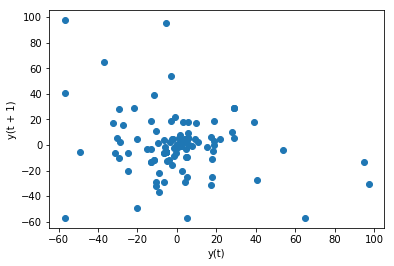

trend removed autocorrelation


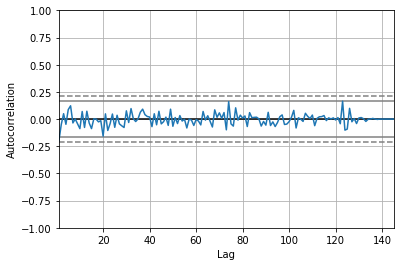

ADF Statistic: -14.566352
p-value: 0.000000
Critical Values:
	5%: -2.882
	1%: -3.477
	10%: -2.578
Region 4: Central San Joaquin Valley, CA|FAIR|Weighted Average : 'Stationary'

---------------------  Region 2: Sacramento Valley, CA|FAIR|Weighted Average  ---------------------
raw data


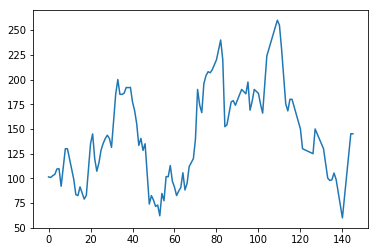

raw data lag ot t+1 / t


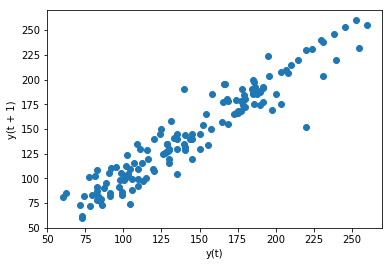

raw data autocorrelation


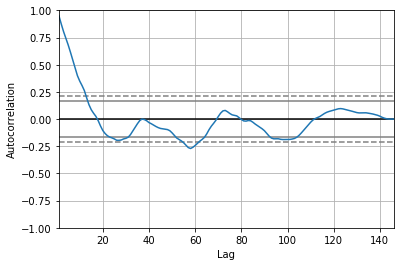

trend removed


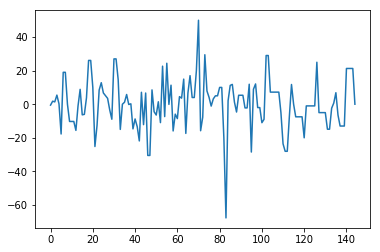

trend removed lag ot t+1 / t


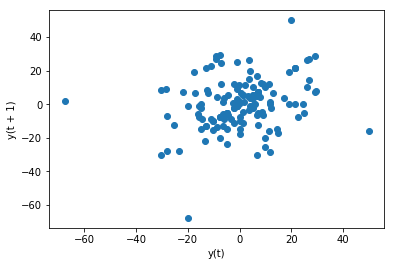

trend removed autocorrelation


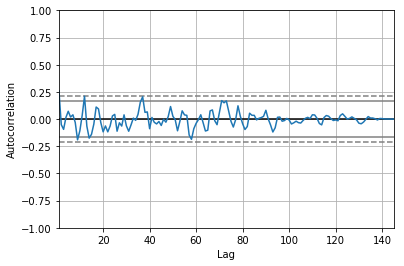

ADF Statistic: -9.140299
p-value: 0.000000
Critical Values:
	5%: -2.882
	1%: -3.477
	10%: -2.578
Region 2: Sacramento Valley, CA|FAIR|Weighted Average : 'Stationary'

---------------------  Region 6: Southeast California, CA|PREMIUM|Weighted Average  ---------------------
raw data


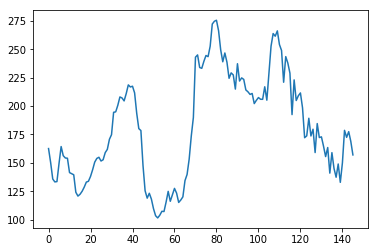

raw data lag ot t+1 / t


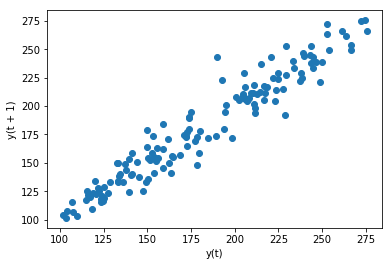

raw data autocorrelation


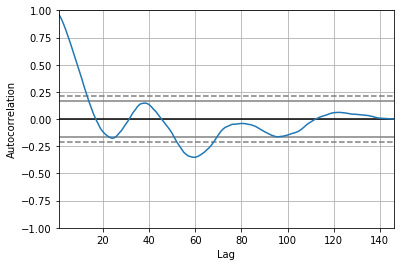

trend removed


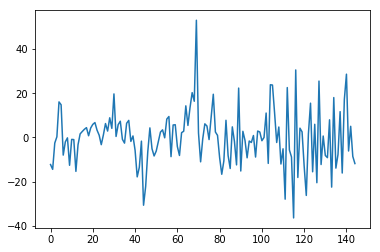

trend removed lag ot t+1 / t


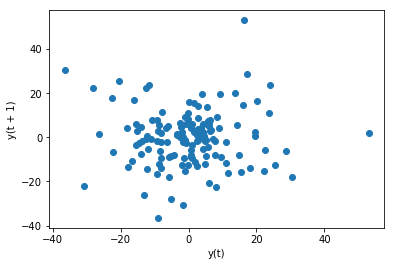

trend removed autocorrelation


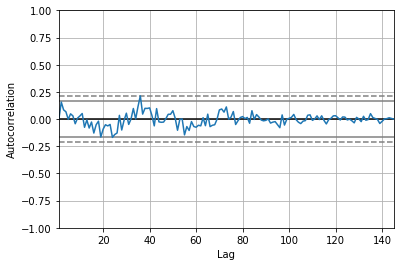

ADF Statistic: -7.183202
p-value: 0.000000
Critical Values:
	5%: -2.882
	1%: -3.477
	10%: -2.578
Region 6: Southeast California, CA|PREMIUM|Weighted Average : 'Stationary'

---------------------  Region 2: Sacramento Valley, CA|GOOD|Weighted Average  ---------------------
raw data


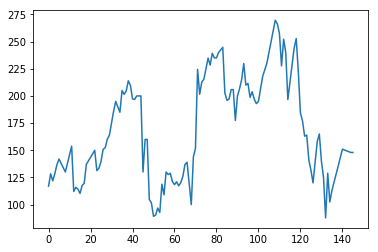

raw data lag ot t+1 / t


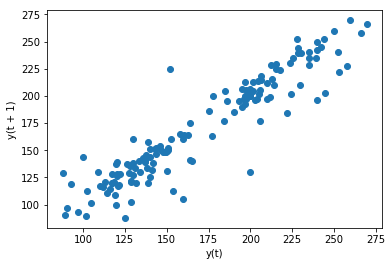

raw data autocorrelation


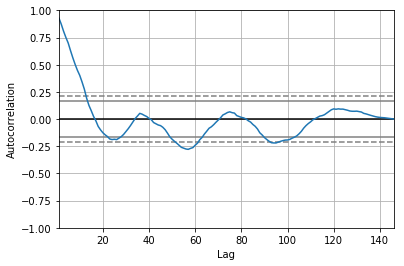

trend removed


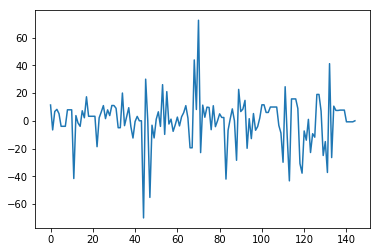

trend removed lag ot t+1 / t


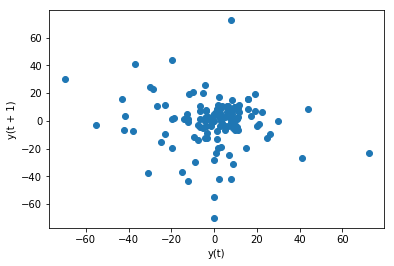

trend removed autocorrelation


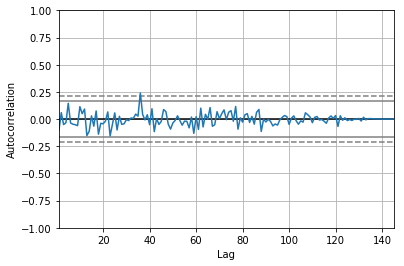

ADF Statistic: -13.218315
p-value: 0.000000
Critical Values:
	5%: -2.882
	1%: -3.477
	10%: -2.578
Region 2: Sacramento Valley, CA|GOOD|Weighted Average : 'Stationary'

---------------------  Region 3: Northern San Joaquin Valley, CA|GOOD|Weighted Average  ---------------------
raw data


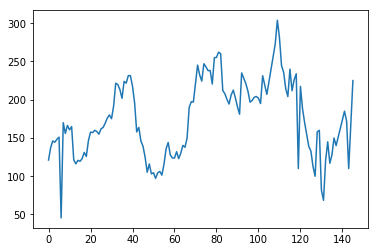

raw data lag ot t+1 / t


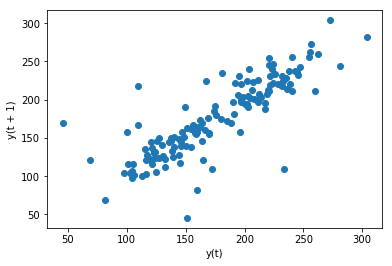

raw data autocorrelation


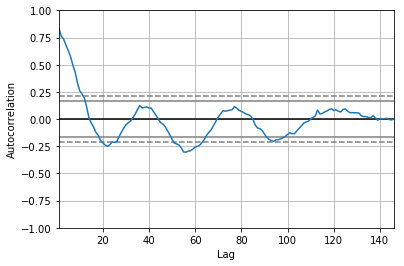

trend removed


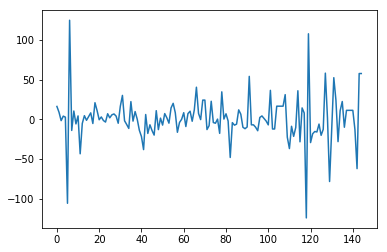

trend removed lag ot t+1 / t


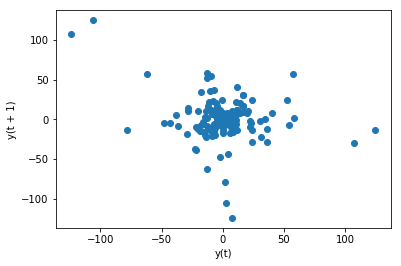

trend removed autocorrelation


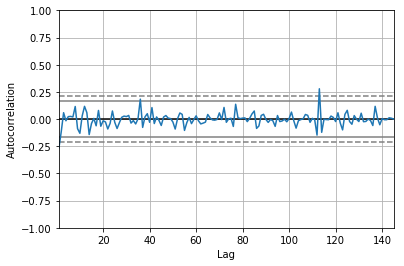

ADF Statistic: -11.384336
p-value: 0.000000
Critical Values:
	5%: -2.882
	1%: -3.477
	10%: -2.578
Region 3: Northern San Joaquin Valley, CA|GOOD|Weighted Average : 'Stationary'

---------------------  Region 5: Southern California, CA|FAIR|Weighted Average  ---------------------
raw data


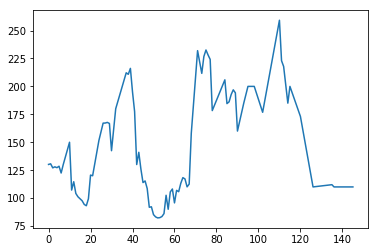

raw data lag ot t+1 / t


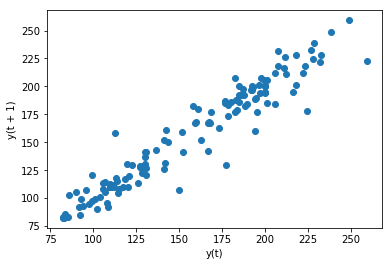

raw data autocorrelation


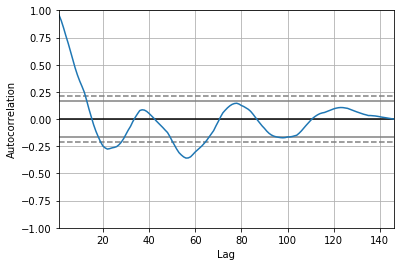

trend removed


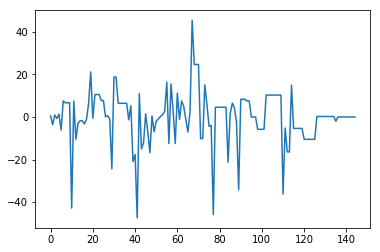

trend removed lag ot t+1 / t


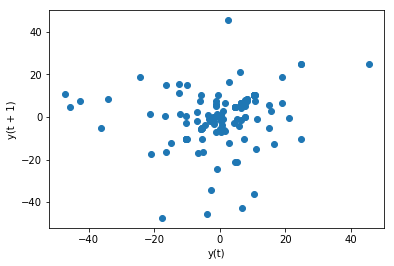

trend removed autocorrelation


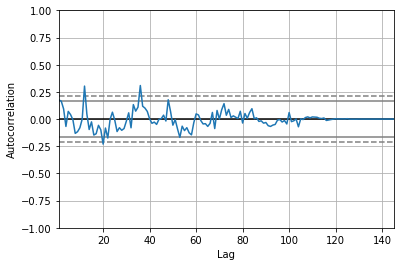

ADF Statistic: -2.991339
p-value: 0.035711
Critical Values:
	5%: -2.884
	1%: -3.481
	10%: -2.579
Region 5: Southern California, CA|FAIR|Weighted Average : 'Stationary'

---------------------  Region 6: Southeast California, CA|SUPREME|Weighted Average  ---------------------
raw data


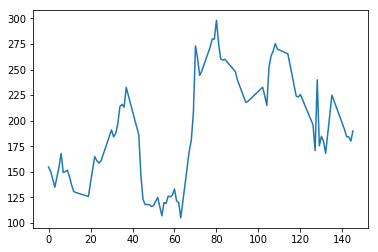

raw data lag ot t+1 / t


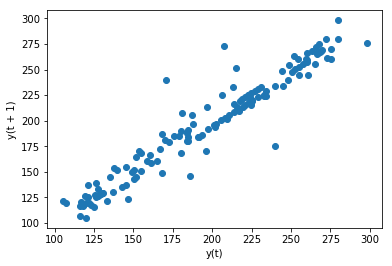

raw data autocorrelation


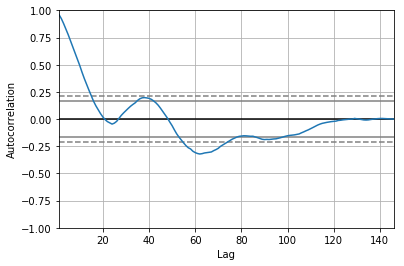

trend removed


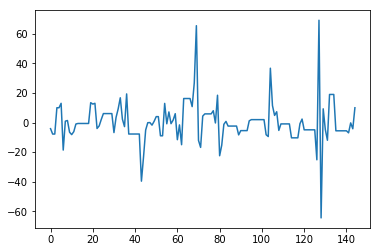

trend removed lag ot t+1 / t


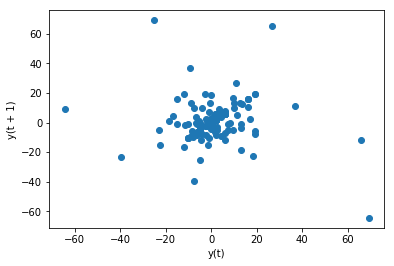

trend removed autocorrelation


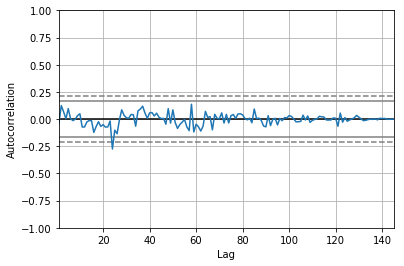

ADF Statistic: -7.545858
p-value: 0.000000
Critical Values:
	5%: -2.882
	1%: -3.477
	10%: -2.578
Region 6: Southeast California, CA|SUPREME|Weighted Average : 'Stationary'

---------------------  Region 1: North Inter-Mountain, CA|GOOD|Weighted Average  ---------------------
raw data


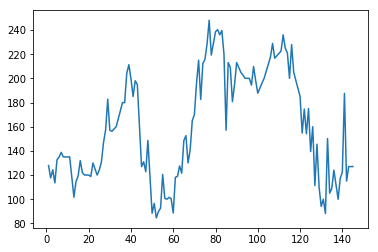

raw data lag ot t+1 / t


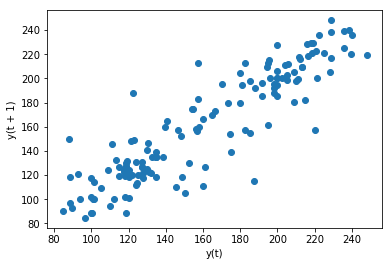

raw data autocorrelation


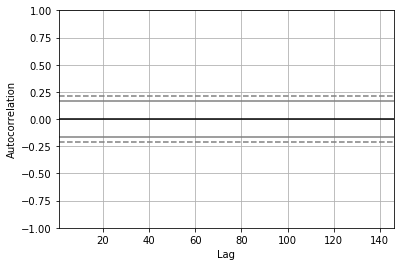

trend removed


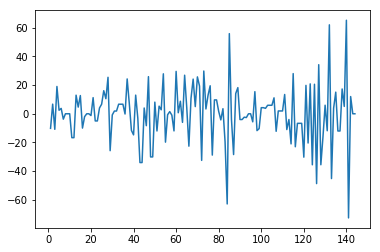

trend removed lag ot t+1 / t


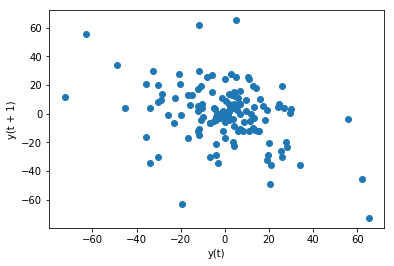

trend removed autocorrelation


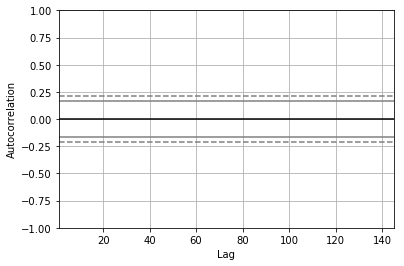

SVD did not converge

---------------------  Region 4: Central San Joaquin Valley, CA|GOOD|Weighted Average  ---------------------
raw data


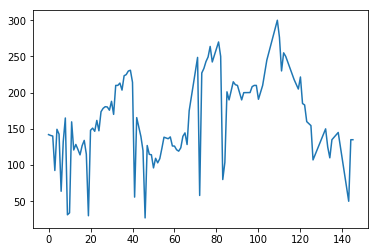

raw data lag ot t+1 / t


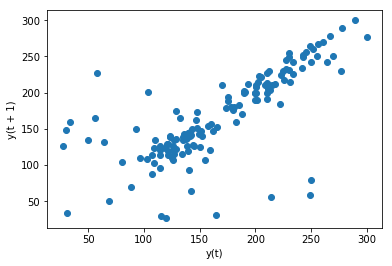

raw data autocorrelation


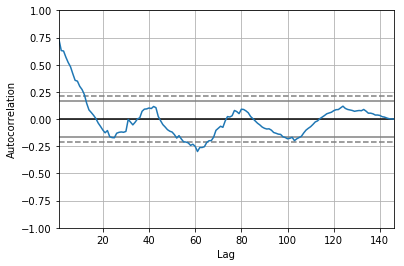

trend removed


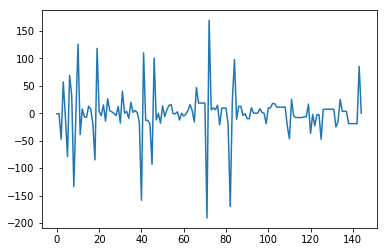

trend removed lag ot t+1 / t


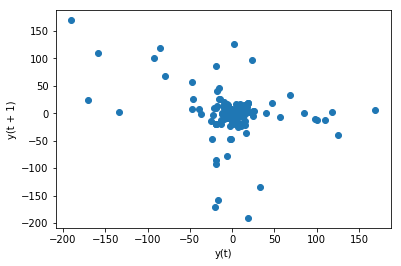

trend removed autocorrelation


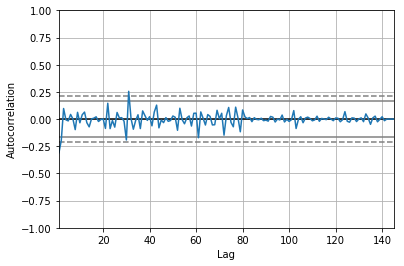

ADF Statistic: -9.798830
p-value: 0.000000
Critical Values:
	5%: -2.882
	1%: -3.477
	10%: -2.578
Region 4: Central San Joaquin Valley, CA|GOOD|Weighted Average : 'Stationary'

---------------------  Region 1: North Inter-Mountain, CA|FAIR|Weighted Average  ---------------------
raw data


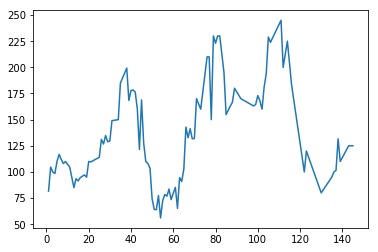

raw data lag ot t+1 / t


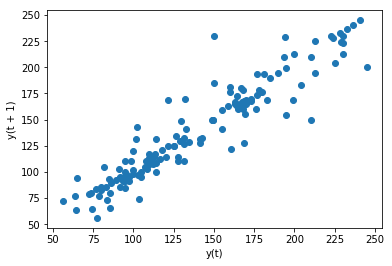

raw data autocorrelation


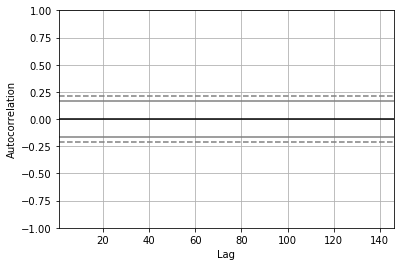

trend removed


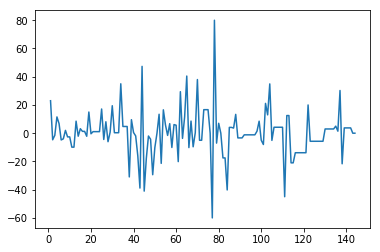

trend removed lag ot t+1 / t


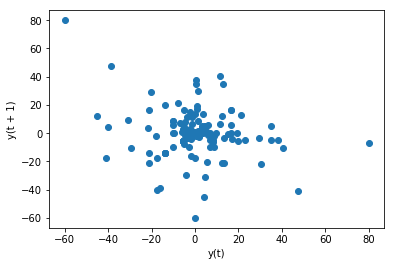

trend removed autocorrelation


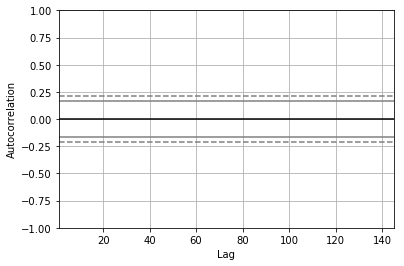

SVD did not converge

---------------------  Region 1: North Inter-Mountain, CA|PREMIUM|Weighted Average  ---------------------
raw data


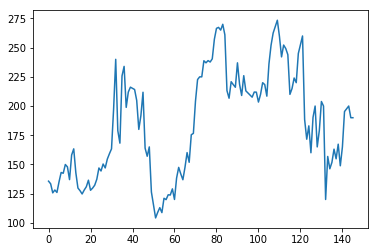

raw data lag ot t+1 / t


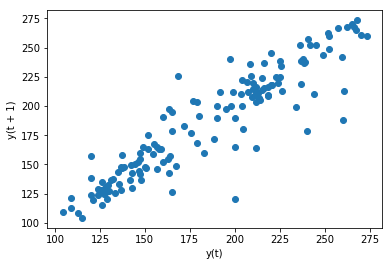

raw data autocorrelation


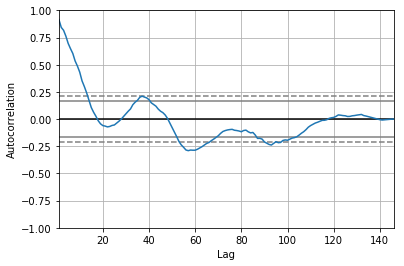

trend removed


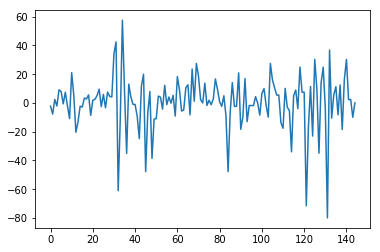

trend removed lag ot t+1 / t


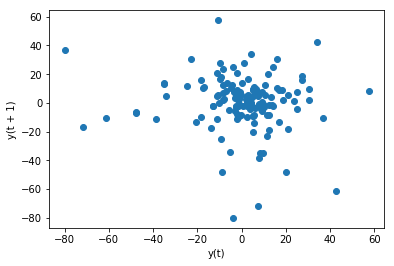

trend removed autocorrelation


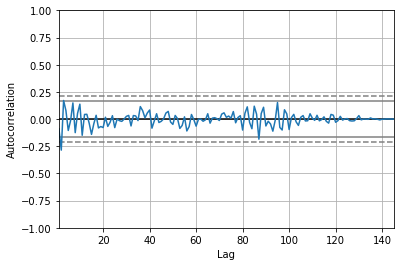

ADF Statistic: -7.346647
p-value: 0.000000
Critical Values:
	5%: -2.882
	1%: -3.477
	10%: -2.578
Region 1: North Inter-Mountain, CA|PREMIUM|Weighted Average : 'Stationary'

---------------------  Region 5: Southern California, CA|GOOD|Weighted Average  ---------------------
raw data


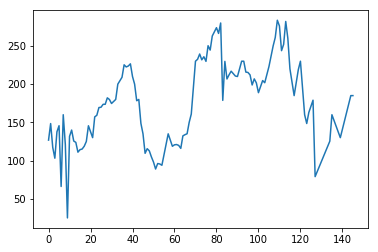

raw data lag ot t+1 / t


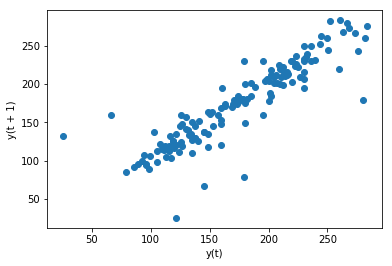

raw data autocorrelation


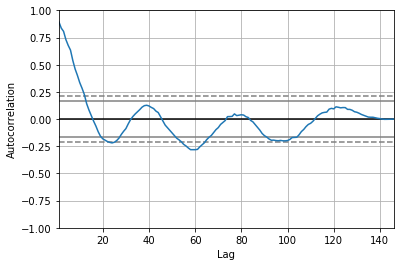

trend removed


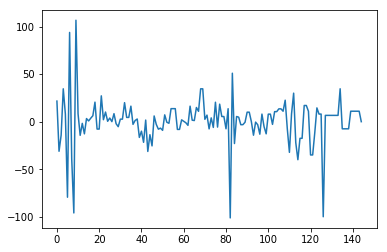

trend removed lag ot t+1 / t


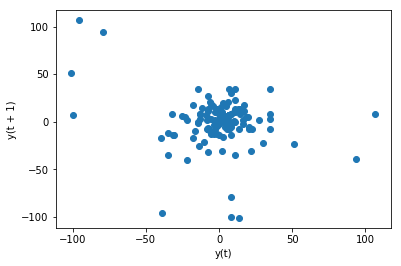

trend removed autocorrelation


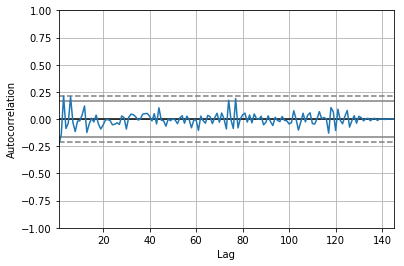

ADF Statistic: -15.133292
p-value: 0.000000
Critical Values:
	5%: -2.882
	1%: -3.477
	10%: -2.578
Region 5: Southern California, CA|GOOD|Weighted Average : 'Stationary'

---------------------  Region 5: Southern California, CA|PREMIUM|Weighted Average  ---------------------
raw data


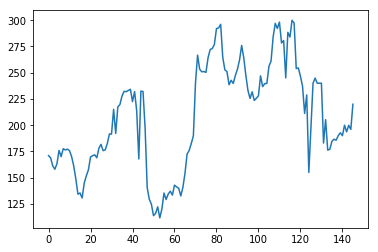

raw data lag ot t+1 / t


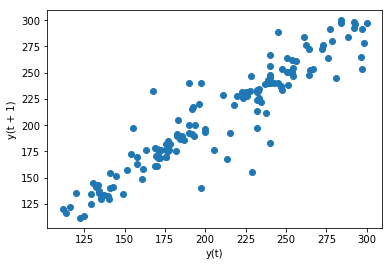

raw data autocorrelation


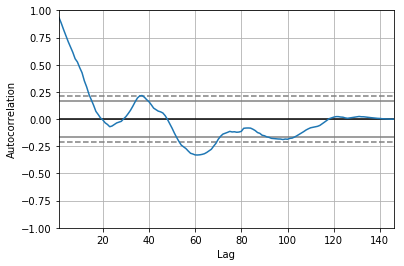

trend removed


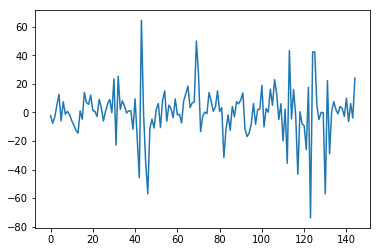

trend removed lag ot t+1 / t


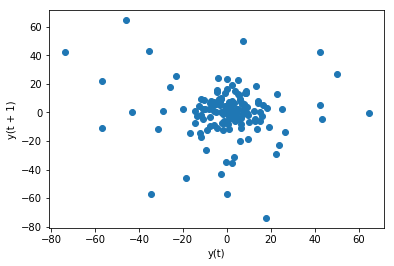

trend removed autocorrelation


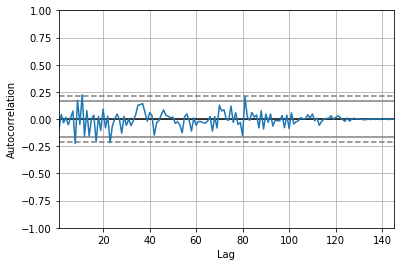

ADF Statistic: -13.033667
p-value: 0.000000
Critical Values:
	5%: -2.882
	1%: -3.477
	10%: -2.578
Region 5: Southern California, CA|PREMIUM|Weighted Average : 'Stationary'

---------------------  Region 4: Central San Joaquin Valley, CA|SUPREME|Weighted Average  ---------------------
raw data


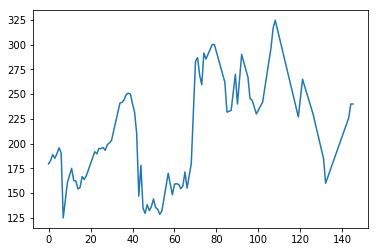

raw data lag ot t+1 / t


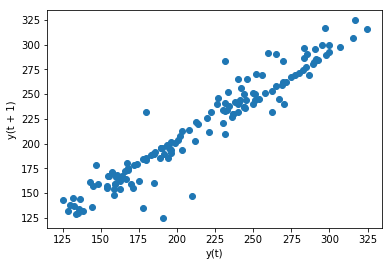

raw data autocorrelation


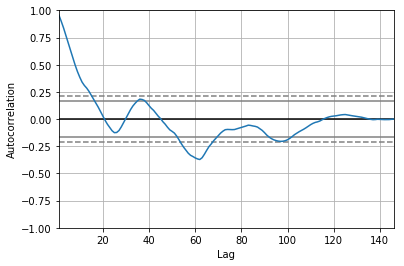

trend removed


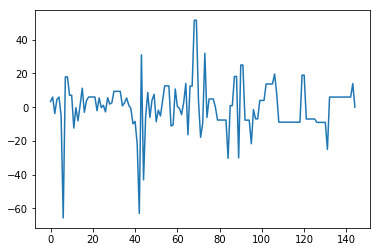

trend removed lag ot t+1 / t


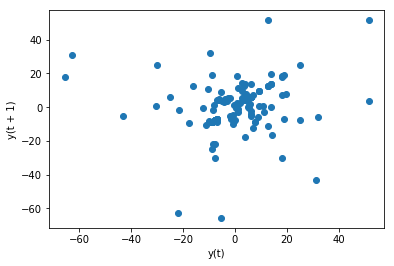

trend removed autocorrelation


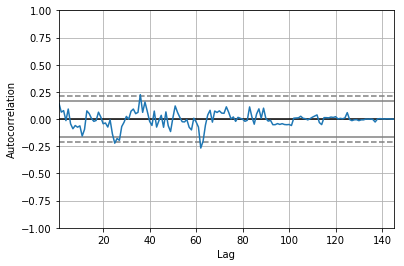

ADF Statistic: -10.281042
p-value: 0.000000
Critical Values:
	5%: -2.882
	1%: -3.477
	10%: -2.578
Region 4: Central San Joaquin Valley, CA|SUPREME|Weighted Average : 'Stationary'

---------------------  Region 6: Southeast California, CA|FAIR|Weighted Average  ---------------------
raw data


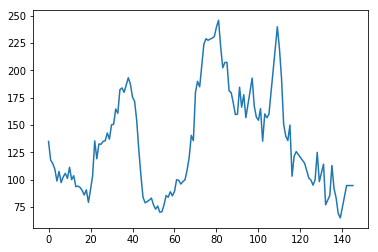

raw data lag ot t+1 / t


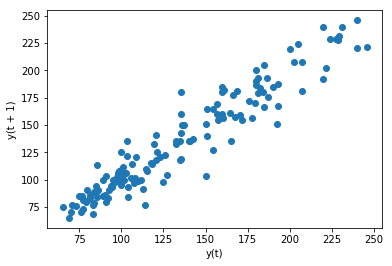

raw data autocorrelation


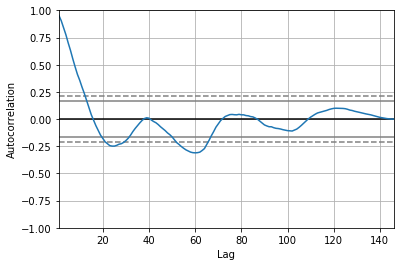

trend removed


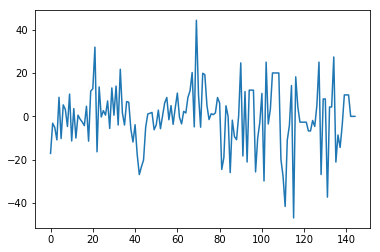

trend removed lag ot t+1 / t


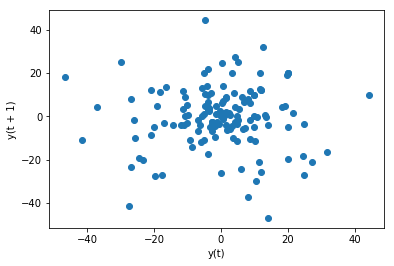

trend removed autocorrelation


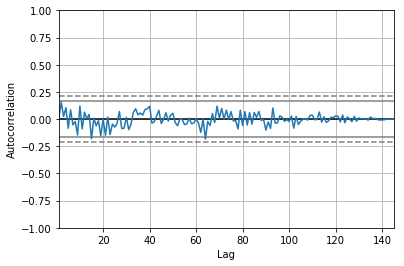

ADF Statistic: -7.108466
p-value: 0.000000
Critical Values:
	5%: -2.882
	1%: -3.477
	10%: -2.578
Region 6: Southeast California, CA|FAIR|Weighted Average : 'Stationary'

---------------------  Region 5: Southern California, CA|SUPREME|Weighted Average  ---------------------
raw data


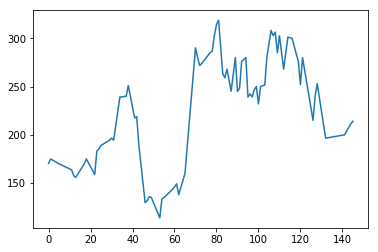

raw data lag ot t+1 / t


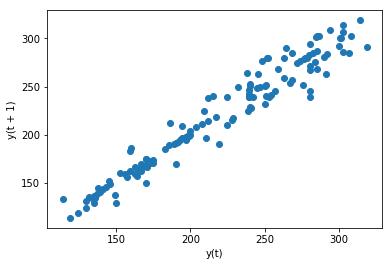

raw data autocorrelation


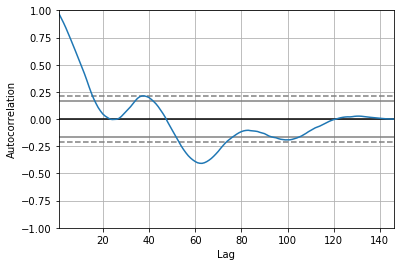

trend removed


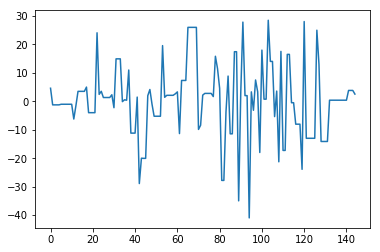

trend removed lag ot t+1 / t


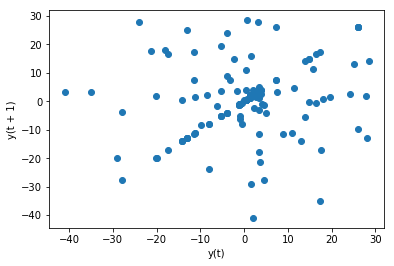

trend removed autocorrelation


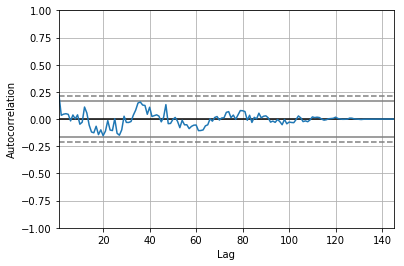

ADF Statistic: -9.525675
p-value: 0.000000
Critical Values:
	5%: -2.882
	1%: -3.477
	10%: -2.578
Region 5: Southern California, CA|SUPREME|Weighted Average : 'Stationary'

---------------------  Region 3: Northern San Joaquin Valley, CA|PREMIUM|Weighted Average  ---------------------
raw data


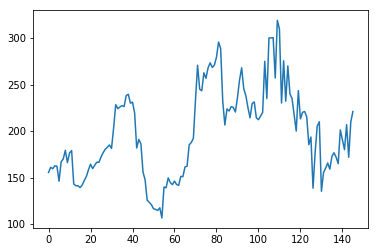

raw data lag ot t+1 / t


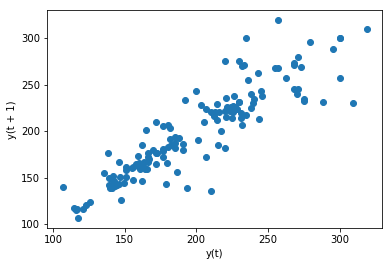

raw data autocorrelation


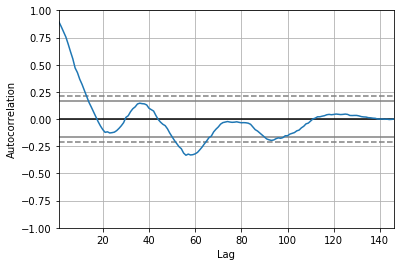

trend removed


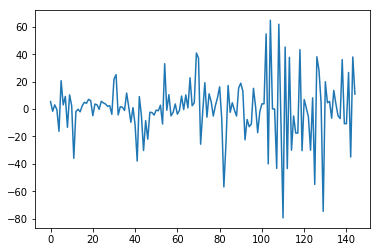

trend removed lag ot t+1 / t


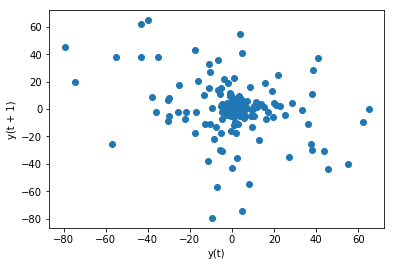

trend removed autocorrelation


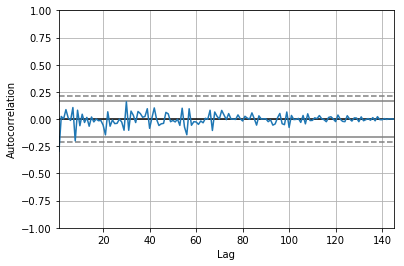

ADF Statistic: -16.166580
p-value: 0.000000
Critical Values:
	5%: -2.882
	1%: -3.477
	10%: -2.578
Region 3: Northern San Joaquin Valley, CA|PREMIUM|Weighted Average : 'Stationary'

---------------------  Region 4: Central San Joaquin Valley, CA|PREMIUM|Weighted Average  ---------------------
raw data


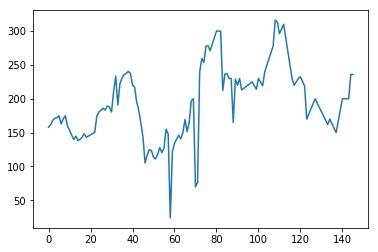

raw data lag ot t+1 / t


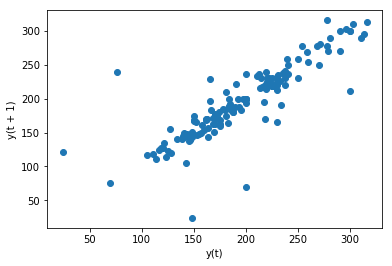

raw data autocorrelation


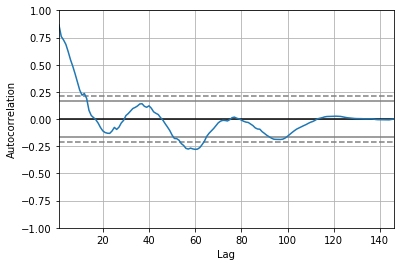

trend removed


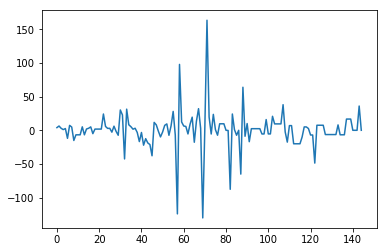

trend removed lag ot t+1 / t


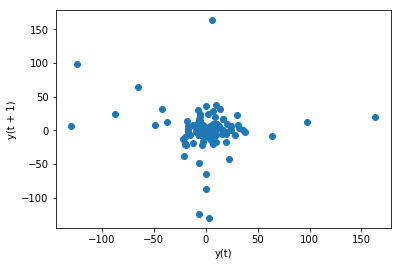

trend removed autocorrelation


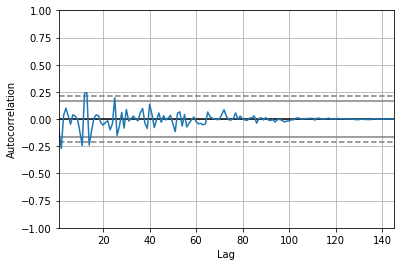

ADF Statistic: -2.943350
p-value: 0.040534
Critical Values:
	5%: -2.884
	1%: -3.481
	10%: -2.579
Region 4: Central San Joaquin Valley, CA|PREMIUM|Weighted Average : 'Stationary'

---------------------  Region 1: North Inter-Mountain, CA|SUPREME|Weighted Average  ---------------------
raw data


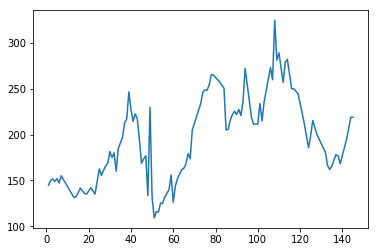

raw data lag ot t+1 / t


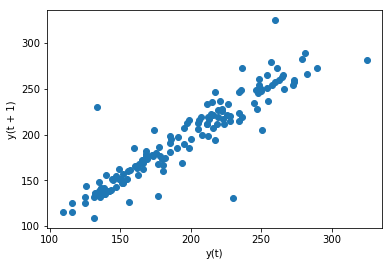

raw data autocorrelation


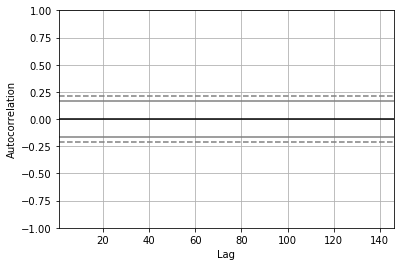

trend removed


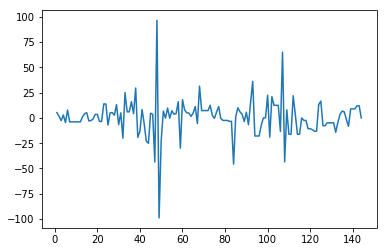

trend removed lag ot t+1 / t


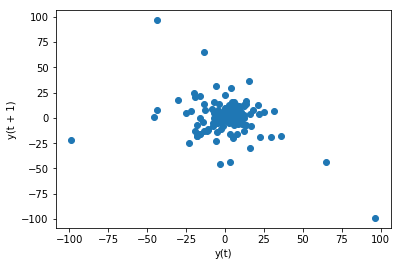

trend removed autocorrelation


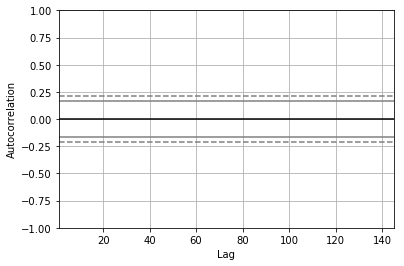

SVD did not converge

---------------------  Region 2: Sacramento Valley, CA|SUPREME|Weighted Average  ---------------------
raw data


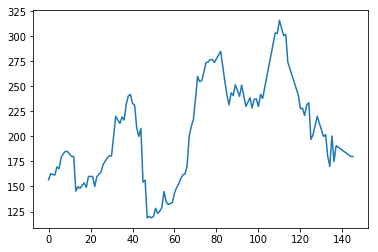

raw data lag ot t+1 / t


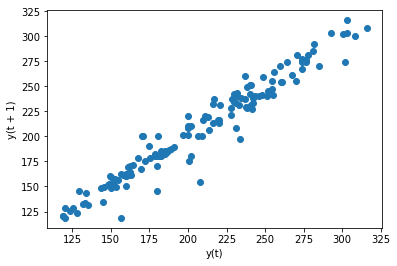

raw data autocorrelation


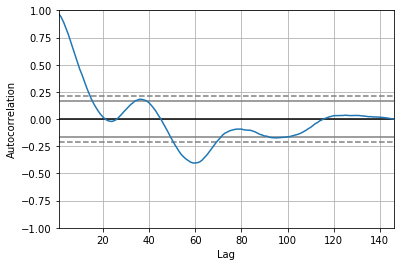

trend removed


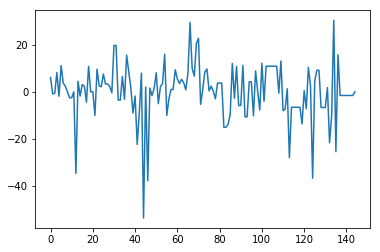

trend removed lag ot t+1 / t


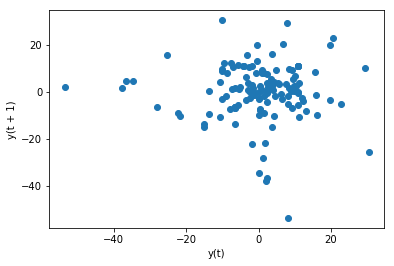

trend removed autocorrelation


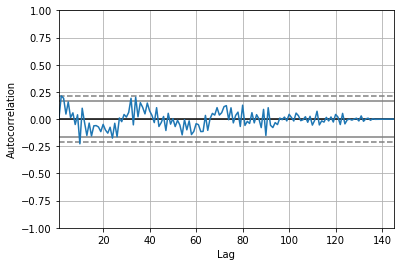

ADF Statistic: -4.737915
p-value: 0.000071
Critical Values:
	5%: -2.882
	1%: -3.477
	10%: -2.578
Region 2: Sacramento Valley, CA|SUPREME|Weighted Average : 'Stationary'


In [101]:
for name in ams_month_price_df_no_year.columns.values:
    series = ams_month_df[name]
    print
    print '--------------------- ',name,' ---------------------'

    #plot the raw data
    print 'raw data'
    pyplot.plot(series)
    pyplot.show()

    #Plot the lag ot t+1 / t
    print 'raw data lag ot t+1 / t'
    lag_plot(series)
    pyplot.show()

    # Plot lags at various intervals
    print 'raw data autocorrelation'
    autocorrelation_plot(series)
    pyplot.show()

    #remove the trend
    print 'trend removed'
    X = series.values
    diff = []
    for i in range(1, len(X)):
        value = X[i] - X[i - 1]
        diff.append(value)
    pyplot.plot(diff)
    pyplot.show()

    series_diff = pd.Series(diff)

    #Plot the lag ot t+1 / t
    print 'trend removed lag ot t+1 / t'
    lag_plot(series_diff)
    pyplot.show()

    # Plot lags at various intervals
    print 'trend removed autocorrelation'
    autocorrelation_plot(series_diff)
    pyplot.show()

    try:
        result = adfuller(series_diff)
        print 'ADF Statistic: %f' % result[0]
        print 'p-value: %f' % result[1]
        print 'Critical Values:'
        for key, value in result[4].items():
            print '\t%s: %.3f' % (key, value)
        print name,': \'Not Stationary\'' if result[1] > 0.05 else ': \'Stationary\''
    except Exception as inst:
        print inst